In [1]:
#导入库
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#导入data
train=pd.read_csv('train.csv')
#查看大小
train.shape
(10886, 12)
#查看data形式
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
#检查缺失值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### 无缺失值 

<AxesSubplot:>

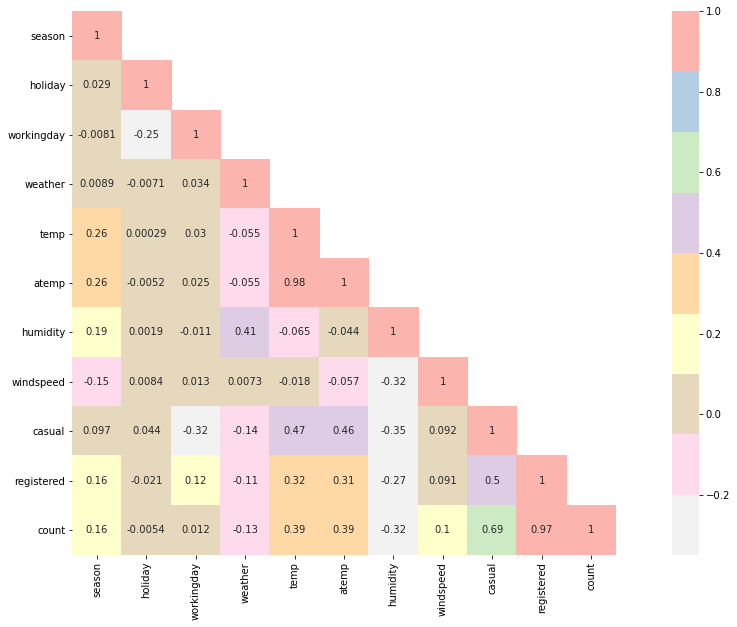

In [3]:
#相关性查看
corrMatrix=train.corr()
#将相关系数矩阵可视化
mask=np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatrix,mask=mask,cmap="Pastel1_r",square=True,annot=True,)

### 其中温度temp，体感温度atemp比一般熟悉强，casual，register与count的相关较强
> 意义  https://zhuanlan.zhihu.com/p/67961875?utm_source=wechat_session
> 
>1.对于casual和register，因为count=casual + register 所以其相关性自然更强
>
>2.对于温度，可以理解温度的变化会对骑行的人数有影响，太冷太热可能都会给骑行带来不便
>
>3.在之后的模型训练时,为了模型的更好的预测,可以对casual普通用户和register注册用户分别训练再求和
>
>4.可见温度对骑行次数有一点程度的影响,考虑对于datatime进行特征提取,分季节,分时间段,分工作和非工作日观测数据的关联性

<AxesSubplot:xlabel='temp', ylabel='count'>

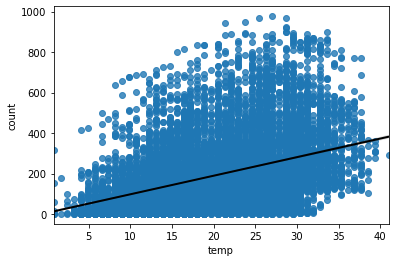

In [4]:
#研究数值型变量对count的影响  regplot
fig.set_size_inches(10,8)
sns.regplot(x='temp',y='count',data=train,line_kws={"color":"black", "linewidth":2})

<AxesSubplot:xlabel='atemp', ylabel='count'>

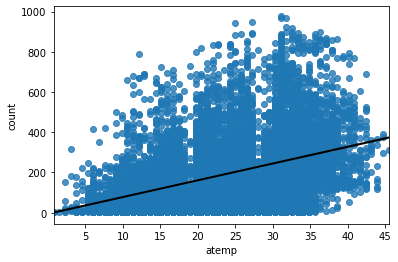

In [5]:
sns.regplot(x='atemp',y='count',data=train,line_kws={"color":"black", "linewidth":2})

### 20-25度的出现高峰,基本有400量的样子,整体温度与次数呈现正相关

<AxesSubplot:xlabel='windspeed', ylabel='count'>

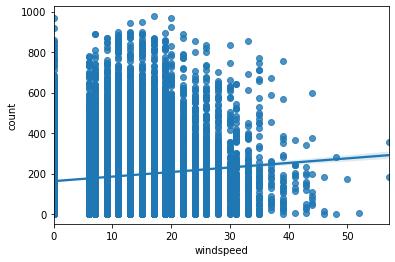

In [6]:
sns.regplot(x='windspeed',y='count',data=train)


次数与风速正相关,在大部分区间都能达到800的次数,在风速过大的天气骑行次数有减少的趋势

In [7]:
#将datetime分拆为date、month、weekday、hour

train['date']=train['datetime'].apply(lambda x:x.split()[0])
train['month']=train['date'].apply(lambda x:x.split("-")[1])     
train['hour']=train['datetime'].apply(lambda x:x.split()[1].split(":")[0])
train['weekday']=train['date'].apply(lambda x:calendar.day_name[datetime.strptime(x,"%Y-%m-%d").weekday()])
#将datetime删掉
train=train.drop(["datetime","date"],axis=1)

#再次查看数据
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,01,00,Saturday
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01,01,Saturday
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,01,02,Saturday
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,01,03,Saturday
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,01,04,Saturday


In [8]:
#将season和weather进行映射
season_dict={1:"spring",2:"summer",3:"autumn",4:"winter"}
train['season']=train['season'].map(season_dict)
weather_dict={1:"sunday",2:"clouday",3:"snowday",4:"rainday"}
train['weather']=train['weather'].map(weather_dict)
#将数值类型进行转换
categoryList=['season','holiday','workingday','weather','month','hour','weekday']
for i in categoryList:
    train[i]=train[i].astype("category")

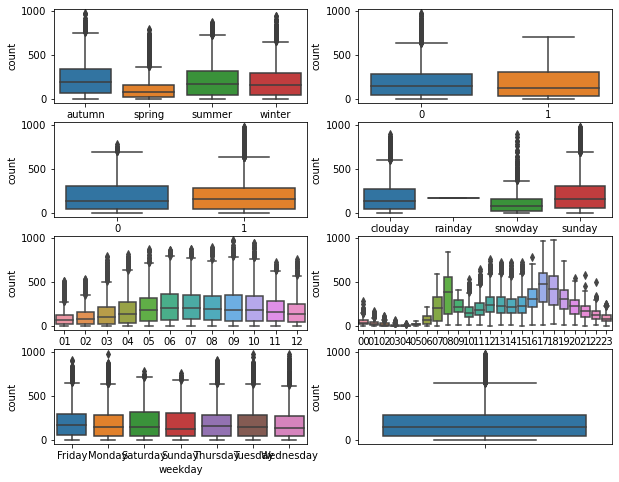

In [9]:
#绘制各个分类变量对count的影响

fig,axes=plt.subplots(4,2) 
fig.set_size_inches(10,8) 


#统一绘制箱型图
ax1=sns.boxplot(data=train,y='count',x='season',orient='v',ax=axes[0][0])
ax2=sns.boxplot(data=train,y='count',x='holiday',orient='v',ax=axes[0][1])
ax3=sns.boxplot(data=train,y='count',x='workingday',orient='v',ax=axes[1][0])
ax4=sns.boxplot(data=train,y='count',x='weather',orient='v',ax=axes[1][1])
ax5=sns.boxplot(data=train,y='count',x='month',orient='v',ax=axes[2][0])
ax6=sns.boxplot(data=train,y='count',x='hour',orient='v',ax=axes[2][1])
ax7=sns.boxplot(data=train,y='count',x='weekday',orient='v',ax=axes[3][0])
ax8=sns.boxplot(y="count",data=train,orient="v",ax=axes[3][1])

> 图一中的除了春季,其他季节都是基本一样,图二可以看出假期的次数略高于非假期
>
> 图三工作日和非工作日次数基本持平,图四看到骑行次数和天气有很大的关系,晴天次数最多,大雨天次数很少
> 
> 图五是图一季节的细化的表示,同样能看出在夏季的骑行次数最多,在天气转凉时的冬春季节次数开始下降,进入淡季>>
> 
> 图六是对于一天中每个小时的次数的表示,在7,8点进入早高峰,在下午17,18点进入晚高峰
>
> 图七能看出在一周中,每天的次数基本差不多,周末会稍微多一些

## 进一步观察工作日和时间段与次数的关系

[Text(0.5, 0, 'Hour'), Text(0, 0.5, 'Count'), None]

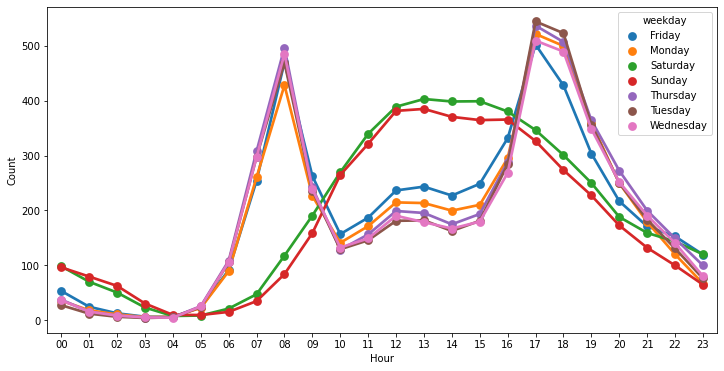

In [10]:
#绘制每个星期每天24小时的使用次数
fig,ax=plt.subplots()
fig.set_size_inches(12,6)
weekdayAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(data=weekdayAggregated,x='hour',y='count',hue='weekday',ax=ax)
ax.set(xlabel='Hour', ylabel='Count',label='big')

可以看出工作日和周末各有相同的变化趋势,说明工作日和非工作日有较为固定的骑行规律,并各不相同
在8点达到早高峰,在17点达到晚高峰

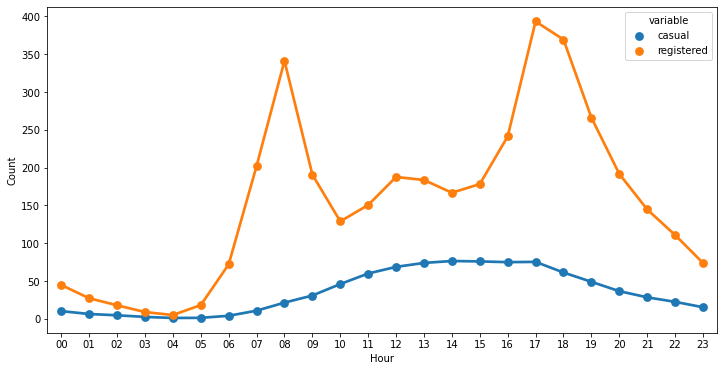

In [11]:
fig,ax=plt.subplots()
fig.set_size_inches(12,6)
data = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
newAggregated=pd.DataFrame(data.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(data=newAggregated,x=newAggregated["hour"],y=newAggregated["value"],hue=newAggregated["variable"],join=True,ax=ax)
ax.set(xlabel='Hour', ylabel='Count',label='big')
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'casual (after transformation)')

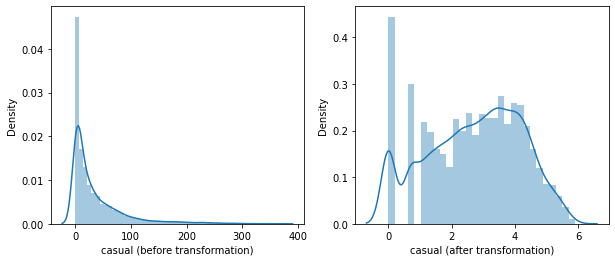

In [12]:
#画出各个值出现的概率
plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.distplot(train['casual'])
plt.xlabel("casual (before transformation)")   #可见在去对数后的数据更具观察性
plt.subplot(122)
sns.distplot(np.log(train['casual'] + 1))
plt.xlabel("casual (after transformation)")


D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


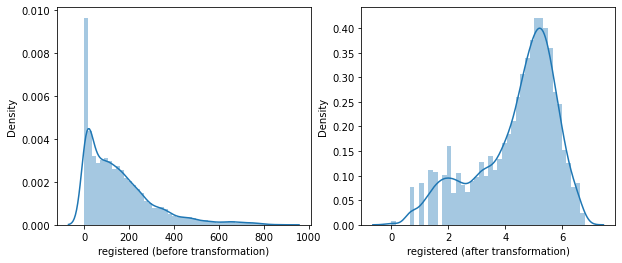

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.distplot(train['registered'])
plt.xlabel("registered (before transformation)")
plt.subplot(122)
sns.distplot(np.log(train['registered'] + 1))
plt.xlabel("registered (after transformation)")
plt.show()

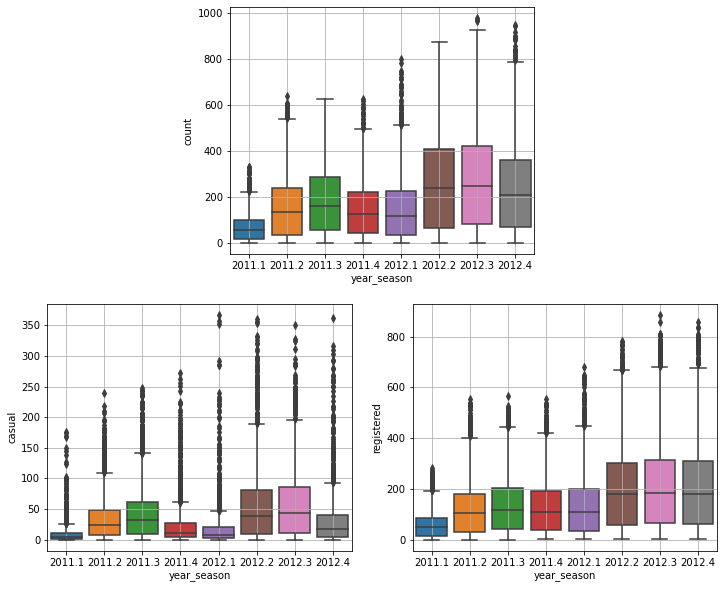

In [14]:
# new feature
# combine year and season
#将season和weather进行映射
from matplotlib.gridspec import GridSpec

train_=pd.read_csv('train.csv')
train_date = pd.DatetimeIndex(train_['datetime']) #转换为时间戳格式：用于索引

train['year'] = train_date.year
train['season']=train_['season'].astype("float")
train['year_season'] = train_date.year + train.season / 10
fig = plt.figure(figsize=(12, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='year_season', y='count', data=train)
plt.grid(True)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='year_season', y='casual', data=train)
plt.grid(True)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='year_season', y='registered', data=train)
plt.grid(True)
plt.show()

In [15]:
# transfer the target from x to log(x + 1)
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)   #将列名变为col_log

In [16]:
train['hour'] = train_date.hour
train['year'] = train_date.year
train['dayofweek'] = train_date.dayofweek
test = pd.read_csv("test.csv")
test_date = pd.DatetimeIndex(test['datetime'])
test['year'] = test_date.year
test['hour'] = test_date.hour
test['dayofweek'] = test_date.dayofweek

In [17]:
# new feature

for df in [train, test]:
    df['year_season'] = df['year'] + df['season'] / 10
    df['hour_workingday_casual'] = df[['hour', 'workingday']].apply(
        lambda x: int(10 <= x['hour'] <= 19), axis=1)
    df['hour_workingday_registered'] = df[['hour', 'workingday']].apply(
      lambda x: int(
        (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18))
        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19)), axis=1)

by_season = train.groupby('year_season')[['count']].median()
by_season.columns = ['count_season']
train = train.join(by_season, on='year_season')
test = test.join(by_season, on='year_season')

In [18]:
weather_dict={"sunday":1,"clouday":2,"snowday":3,"rainday":4}
train['weather']=train['weather'].map(weather_dict)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split( train, test_size=0.1, random_state=42)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
#训练普通用户使用次数
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_casual', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(X_train[features], X_train['casual_log'])
pred_casual = reg.predict(test[features])
pred_casual_valid = reg.predict(X_valid[features])
pred_casual = np.exp(pred_casual) - 1
pred_casual_valid = np.exp(pred_casual_valid) - 1
pred_casual[pred_casual < 0] = 0
pred_casual_valid[pred_casual_valid < 0] = 0
#训练注册用户使用次数
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_registered', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(X_train[features], X_train['registered_log'])
pred_registered = reg.predict(test[features])
pred_registered = np.exp(pred_registered) - 1
pred_registered[pred_registered < 0] = 0

pred_registered_valid = reg.predict(X_valid[features])
pred_registered_valid = np.exp(pred_registered_valid) - 1
pred_registered_valid[pred_registered_valid < 0] = 0
#汇总最终结果
pred = pred_casual + pred_registered
pred_valid = pred_casual_valid + pred_registered_valid

In [21]:
X_valid['predict_count'] =  pred_valid

<ipython-input-21-133a762cecf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['predict_count'] =  pred_valid


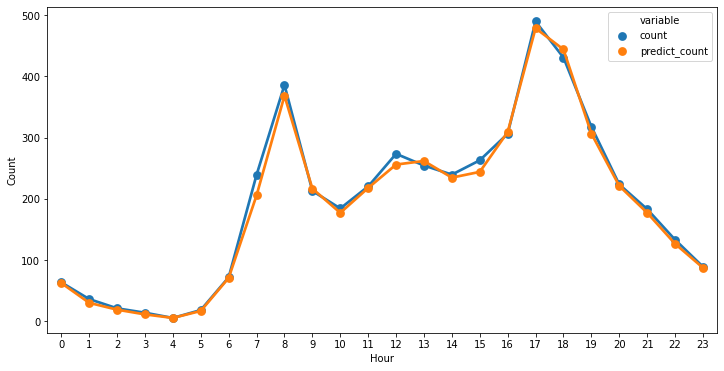

In [22]:
fig,ax=plt.subplots()
fig.set_size_inches(12,6)
data = pd.melt(X_valid[["hour","count","predict_count"]], id_vars=['hour'], value_vars=['count', 'predict_count'])
newAggregated=pd.DataFrame(data.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(data=newAggregated,x=newAggregated["hour"],y=newAggregated["value"],hue=newAggregated["variable"],join=True,ax=ax)
ax.set(xlabel='Hour', ylabel='Count',label='big')
plt.show()

In [23]:
# GradientBoostingRegressor
# rank 4７/3251 public score 0.36904
submission = pd.DataFrame({'datetime':test.datetime, 'count':pred},
                          columns = ['datetime', 'count'])
submission.to_csv("submission.csv", index=False)